In [1]:
import os.path
from os import path
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import TensorBoard
from scripts.utils import *
import sklearn
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from time import strftime

try:
    __import__("wget")
    import wget
    print("wget import exists")
    if(not path.exists("data")):
        print("Making Directory data")
        os.mkdir("data")   
    if(not path.exists("data/control.xls")):
        print("Downloading control.xls")
        wget.download("https://raw.githubusercontent.com/smithandrewk/sleep/main/data/control.xls","data/control.xls")
    if(not path.exists("data/deprivation.xls")):
        print("Downloading deprivation.xls")
        wget.download("https://raw.githubusercontent.com/smithandrewk/sleep/main/data/deprivation.xls","data/deprivation.xls")
    if(not path.exists("scripts")):
        print("Making Directory scripts")
        os.mkdir("scripts")   
    if(not path.exists("scripts/utils.py")):
        print("Downloading utils.py")
        wget.download("https://raw.githubusercontent.com/smithandrewk/sleep/main/scripts/utils.py","scripts/utils.py")
except ImportError:
    print("wget import does not exist, using python2.7 wget")
    if(not path.exists("data")):
        print("Making Directory data")
        !mkdir data   
    if(not path.exists("data/control.xls")):
        print("control.xls not in data")
        !wget -O data/control.xls https://raw.githubusercontent.com/smithandrewk/sleep/main/data/control.xls
    if(not path.exists("data/deprivation.xls")):
        print("deprivation.xls not in data")
        !wget -O data/deprivation.xls https://raw.githubusercontent.com/smithandrewk/sleep/main/data/deprivation.xls
    if(not path.exists("scripts")):
        print("Making Directory scripts")
        !mkdir scripts
    if(not path.exists("scripts/utils.py")):
        !wget -O scripts/utils.py https://raw.githubusercontent.com/smithandrewk/sleep/main/scripts/utils.py
control = preprocess("control")
deprivation = preprocess("deprivation")
control_deprivation = pd.concat([control,deprivation])
control_deprivation.to_csv("data/controldeprivation_preprocessed.csv",index=False)
p,s,w = class_count(control)
p,s,w = class_count(deprivation)
p,s,w = class_count(control_deprivation)

wget import exists
Examples:
    Total: 8641
    P: 367 (4.25% of total)
    S: 3965 (45.89% of total)
    W: 4309 (49.87% of total)

Examples:
    Total: 8641
    P: 614 (7.11% of total)
    S: 3294 (38.12% of total)
    W: 4733 (54.77% of total)

Examples:
    Total: 17282
    P: 981 (5.68% of total)
    S: 7259 (42.00% of total)
    W: 9042 (52.32% of total)



In [2]:
target_filename = 'controldeprivation' # or 'control' or 'deprivation'

In [3]:
df = pd.read_csv("data/"+target_filename+"_preprocessed.csv")

## Windowing
Y = pd.DataFrame()
for i in tqdm(range(len(df)-4)):
    win = df.iloc[i:i+5]
    c = np.argmax(np.bincount(win['Class']))
    del win['Class']
    x = win.values.flatten()
    x = np.insert(x,0,c)
    X = pd.DataFrame(x).T
    X = X.rename({0: 'Class'}, axis='columns')
    Y = pd.concat([Y,X])
df_win = Y
df_win = df_win.reset_index()
del df_win['index']
df_win['Class'] = df_win['Class'].astype(int)
df = df_win

df.to_csv("data/"+target_filename+"_windowed.csv",index=False)

100%|██████████| 17278/17278 [04:16<00:00, 67.40it/s]


In [4]:
df = pd.read_csv("data/"+target_filename+"_windowed.csv")

## Balancing
# TODO : balancing algorithm
ps = df.loc[df["Class"]==0]
ss = df.loc[df["Class"]==1]
ws = df.loc[df["Class"]==2]
for i in range(int(w/p)):
  df = pd.concat([df,ps])
p,s,w = class_count(df)

df.to_csv("data/"+target_filename+"_windowed_balanced.csv",index=False)

Examples:
    Total: 26116
    P: 9820 (37.60% of total)
    S: 7240 (27.72% of total)
    W: 9056 (34.68% of total)



In [5]:
df = pd.read_csv("data/"+target_filename+"_windowed_balanced.csv")

# Use a utility from sklearn to split and shuffle our dataset.
train_df, test_df = train_test_split(df, test_size=0.2)
train_df, val_df = train_test_split(train_df, test_size=0.2)

# Form np arrays of labels and features.
train_labels = np.array(train_df.pop('Class'))
p_train_labels = train_labels == 0
s_train_labels = train_labels == 1
w_train_labels = train_labels == 2

val_labels = np.array(val_df.pop('Class'))
test_labels = np.array(test_df.pop('Class'))

train_features = np.array(train_df)
val_features = np.array(val_df)
test_features = np.array(test_df)
total = p + s + w
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_p = (1 / p)*(total)/2.0 
weight_for_w = (1 / w)*(total)/2.0
weight_for_s = (1 / s)*(total)/2.0


class_weight = {0: weight_for_p, 1: weight_for_s, 2: weight_for_w}

print('Weight for class 0: {:.2f}'.format(weight_for_p))
print('Weight for class 1: {:.2f}'.format(weight_for_s))
print('Weight for class 2: {:.2f}'.format(weight_for_w))

Weight for class 0: 1.33
Weight for class 1: 1.80
Weight for class 2: 1.44


In [8]:
def train(INPUT_FEATURES,hln=20,EPOCHS=100,BATCH_SIZE=200,weights=False):
    model = get_compiled_model(hln,INPUT_FEATURES=INPUT_FEATURES,dropout=True)
    """
    We one-hot encode the targets. Mathematically, this is good for calculating
    loss. CategoricalCrossEntropy simplifies to a negative log when targets are
    one-hot encoded. However, I simply recieved an error from model.fit when I 
    did not one-hot encode.
      @y : targets
      @depth : number of targets
    """
    # Callback choices
    plot_losses = TrainingPlot()
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='categorical_accuracy', 
        verbose=1,
        patience=100,
        mode='max',
        restore_best_weights=True)
    tensorboard = TensorBoard(log_dir='logs/{}'.format(time()))
    if(weights):
        baseline_history = model.fit(
            train_features,
            tf.one_hot(train_labels,depth=3),
            batch_size=BATCH_SIZE,
            epochs=EPOCHS,
            validation_data=(val_features, tf.one_hot(val_labels,depth=3)),
            callbacks=[early_stopping],
            class_weight=class_weight)
    else:
        baseline_history = model.fit(
        train_features,
        tf.one_hot(train_labels,depth=3),
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=(val_features, tf.one_hot(val_labels,depth=3)),
        callbacks=[early_stopping])
    train_predictions_baseline = model.predict(train_features, batch_size=BATCH_SIZE)
    test_predictions_baseline = model.predict(test_features, batch_size=BATCH_SIZE)
    baseline_results = model.evaluate(test_features, tf.one_hot(test_labels,depth=3),
                                      batch_size=BATCH_SIZE, verbose=0)
    plot_cm(tf.one_hot(test_labels,depth=3).numpy().argmax(axis=1),test_predictions_baseline.argmax(axis=1),baseline_results,hln)
    date = strftime('%X %x').replace("/","").split()
    plt.savefig("figures/"+str(date[1])+"@"+str(date[0][:5].replace(":",""))+"_"+str(hln)+".png",bbox_inches='tight')
    return baseline_history,baseline_results,date,model

 0.2985 - val_categorical_accuracy: 0.9426 - val_precision: 0.6228 - val_recall: 0.9220 - val_auc: 0.8536
Epoch 321/1000
84/84 [==============================] - 1s 12ms/step - loss: 0.2887 - categorical_accuracy: 0.9116 - precision: 0.5466 - recall: 0.8530 - auc: 0.7960 - val_loss: 0.2978 - val_categorical_accuracy: 0.9409 - val_precision: 0.6250 - val_recall: 0.8952 - val_auc: 0.8509
Epoch 322/1000
84/84 [==============================] - 1s 11ms/step - loss: 0.2899 - categorical_accuracy: 0.9052 - precision: 0.5528 - recall: 0.8305 - auc: 0.7897 - val_loss: 0.2904 - val_categorical_accuracy: 0.9435 - val_precision: 0.6118 - val_recall: 0.9280 - val_auc: 0.8523
Epoch 323/1000
84/84 [==============================] - 1s 12ms/step - loss: 0.2890 - categorical_accuracy: 0.9114 - precision: 0.5475 - recall: 0.8446 - auc: 0.7915 - val_loss: 0.2930 - val_categorical_accuracy: 0.9433 - val_precision: 0.6235 - val_recall: 0.8985 - val_auc: 0.8502
Epoch 324/1000
84/84 [=======================

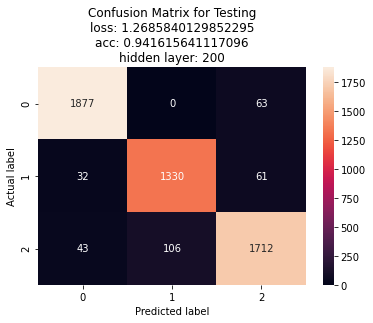

In [10]:
train_history,test_history,date,model = train(INPUT_FEATURES=(train_features.shape[-1],),
                                   hln=200,
                                   EPOCHS=1000,
                                   weights=True)

In [1]:
model.save('./model')

NameError: name 'model' is not defined

In [ ]:
trains = []
tests = []
for i in range(5):
    train_history,test_history,date = train(INPUT_FEATURES=(train_features.shape[-1],),
                                   hln=200,
                                   EPOCHS=1000,
                                   weights=True)
    trains.append(train_history)
    tests.append(test_history)

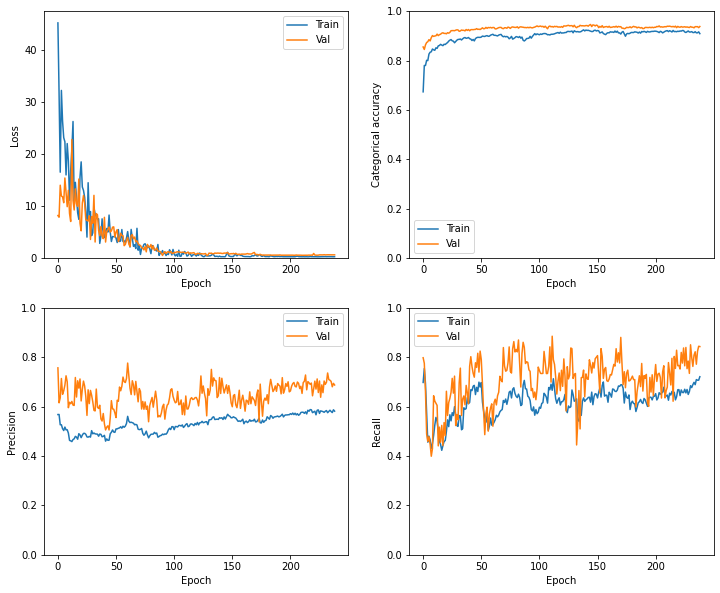

In [17]:
plot_metrics(train_history)
plt.savefig("figures/"+str(date[1])+"@"+str(date[0][:5].replace(":",""))+"_training.png",bbox_inches='tight')